# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train, s_train, coord_train = train['features'], train['labels'], train['sizes'], train['coords']
X_valid, y_valid, s_valid, coord_valid = valid['features'], valid['labels'], valid['sizes'], valid['coords']
X_test, y_test,s_test, coord_test = test['features'], test['labels'], test['sizes'], test['coords']

In [2]:
# load the labels into panda
import pandas as pd
sign_names = pd.read_csv("signnames.csv")


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height of the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [25]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)

print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_image_row(images, height=2):
    img_count = len(images)
    f, plots = plt.subplots(1, img_count, figsize=(img_count*height, height))
    f.tight_layout()
    for plot, image in zip(plots, images):
        plot.imshow(image)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

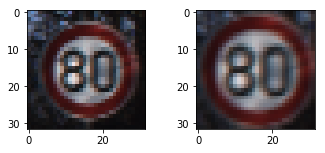

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def recenter(X_data, size, coords):
    # resize to original size
    image = cv2.resize(X_data, (size[0], size[1]))
    # clip the bounding box of the traffic sign
    image = image[coords[0]:coords[2], coords[1]:coords[3]]
    try:
        # resize back to 32x32
        image = cv2.resize(image, (32, 32)) 
    except:
        return X_data
    return image

def recenterList(images, sizes, coords):
    return np.array([recenter(x, s, c) for x, s, c in zip(images, sizes, coords)])

X2_train = recenterList(X_train, s_train, coord_train)
X2_valid = recenterList(X_valid, s_valid, coord_valid)
X2_test = recenterList(X_test, s_test, coord_test)

index = random.randint(0, len(X_test))
image = recenter(X_test[index], s_test[index], coord_test[index])
show_image_row([X_test[index], image])

### Let see how these traffic signs look like

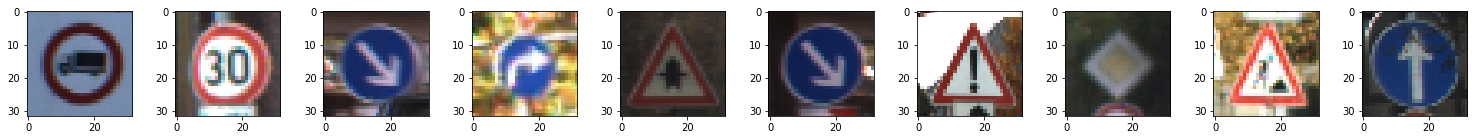

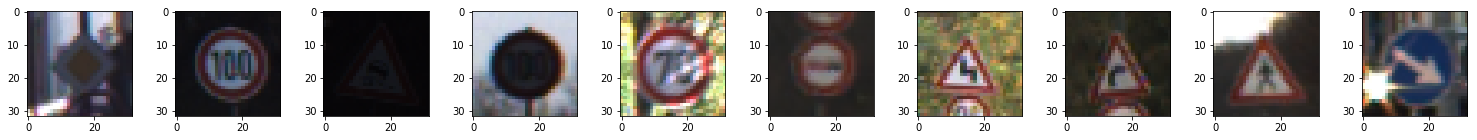

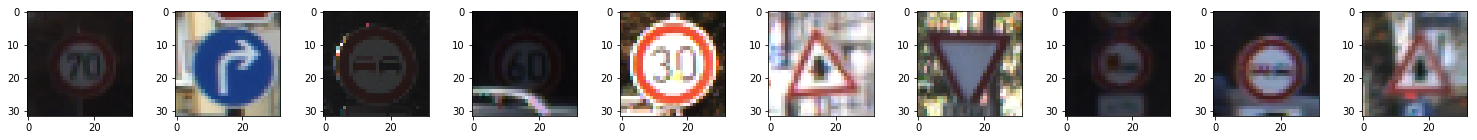

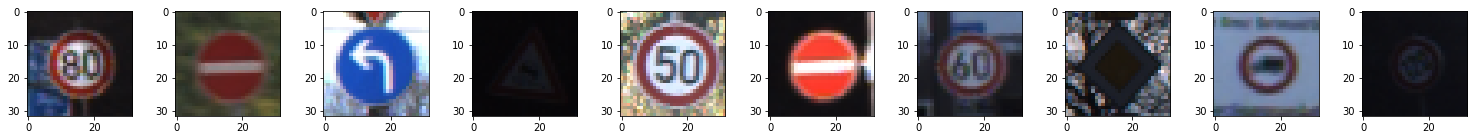

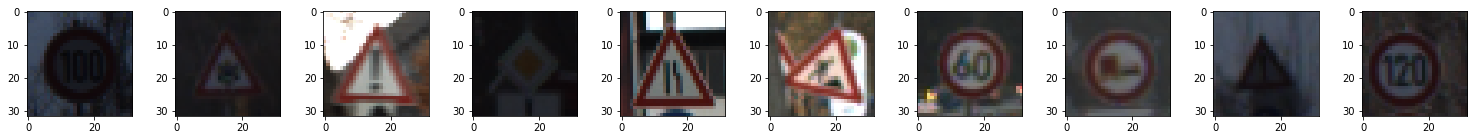

In [6]:
show_image_row(X_test[0:10:])
show_image_row(X_test[10:20:])
show_image_row(X_test[20:30:])
show_image_row(X_test[30:40:])
show_image_row(X_test[40:50:])

### Some statistics of the data set

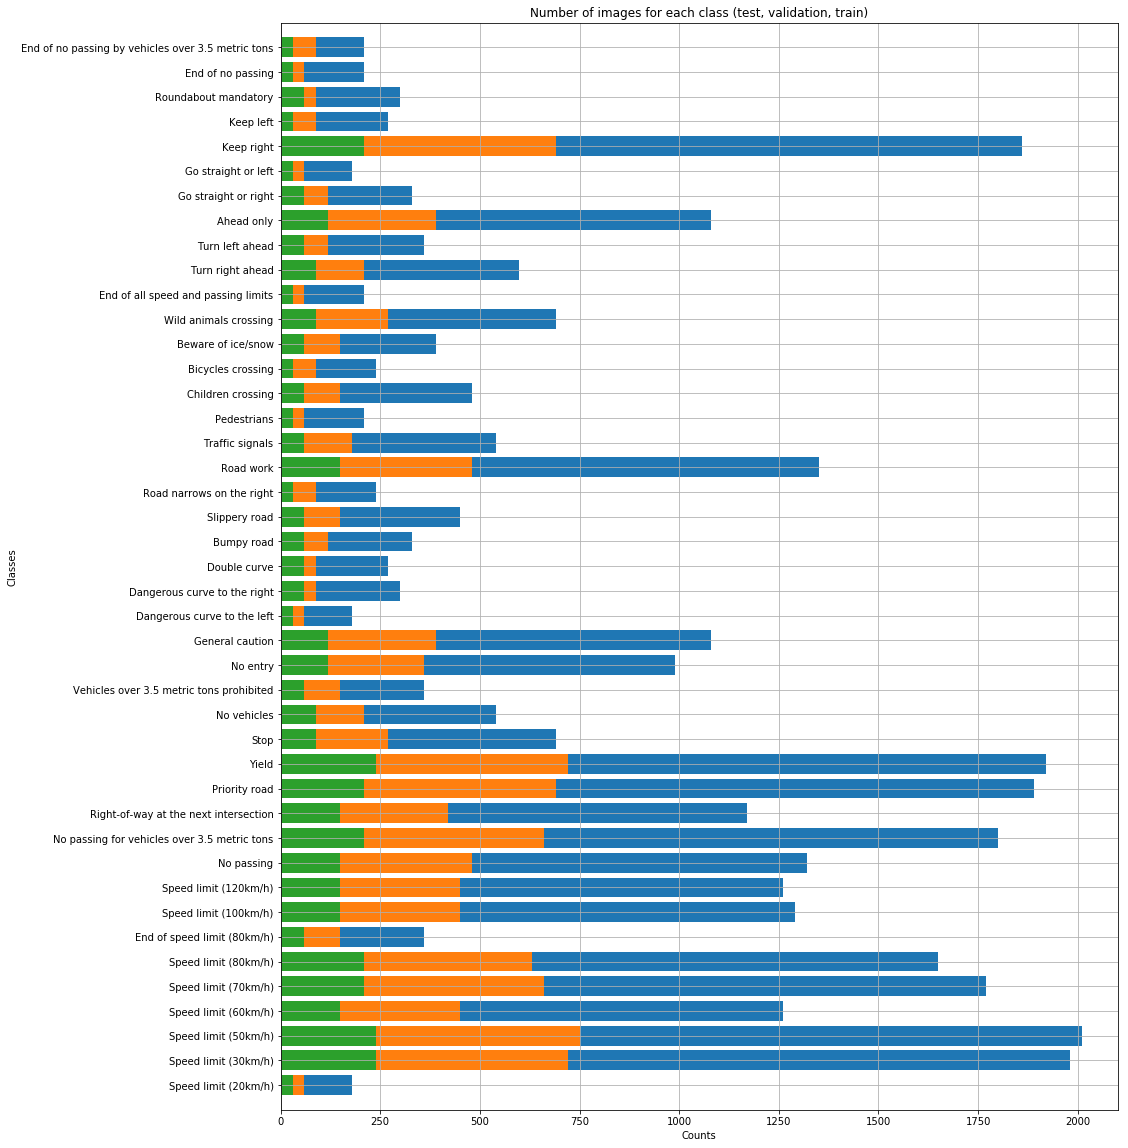

In [26]:
_, train_counts = np.unique(y_train, return_counts=True)
_, validation_counts = np.unique(y_valid, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)

names = sign_names.SignName
plt.barh(names, train_counts)
plt.barh(names, test_counts)
plt.barh(names, validation_counts)

plt.ylabel('Classes')
plt.xlabel('Counts')
plt.title('Number of images for each class (test, validation, train)')
plt.axis([0, 2100, -1, 43])
plt.rcParams["figure.figsize"] = [15, 20]
plt.grid(True)

plt.show()

----

## Step 2: Design and Test a Model Architecture

#### Data pre-porcessing includes a pipeline consisting of grayscaling -> reshaping from (32,32) to (32,32,1) -> normalization  

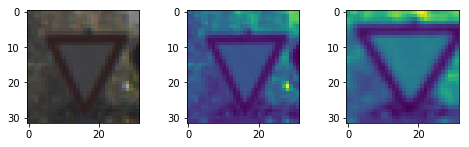

In [8]:
import cv2
from numpy import newaxis

def normalize(data):
    return data/255.0 - 0.5

def grayscale(data):
    return np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in data]) 

def reshape(data):
    return data.reshape(len(data), 32, 32, 1) 

grays = grayscale(X_train)

X_train_normalized = normalize(reshape(grayscale(X2_train)))
X_valid_normalized = normalize(reshape(grayscale(X2_valid)))
X_test_normalized = normalize(reshape(grayscale(X2_test)))

index = random.randint(0, len(X_train))
img = X_train[index].copy()

show_image_row([X_train[index], grays[index], X_train_normalized[index].squeeze()])

### Shuffle the train data

In [9]:
from sklearn.utils import shuffle
X_train_normalized, y_train = shuffle(X_train_normalized, y_train)

### Model Architecture

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

def get_lenet_keras_model():
    model = Sequential()
    conv1 = Conv2D(7, 3, input_shape=(32, 32, 1))
    model.add(conv1)
    model.add(MaxPooling2D(2))
    model.add(Activation('relu'))
    conv2 = Conv2D(16, 5)
    model.add(conv2)
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.25))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(220))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(120))
    model.add(Activation('relu'))
    model.add(Dense(43))
    model.add(Activation('softmax'))
    return model, conv1, conv2

Using TensorFlow backend.


### The Network architecture looks like this:

In [11]:
model, conv1, conv2 = get_lenet_keras_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 7)         70        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 7)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 15, 15, 7)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 16)        2816      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 16)          0         
_________________________________________________________________
activation_2 (Activation)    (None, 5, 5, 16)          0         
__________

### Train, Validate and Test the Model

In [12]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y_train)
y_one_hot_valid = label_binarizer.fit_transform(y_valid)

# compile and fit model
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_train_normalized, y_one_hot, epochs=20, validation_data=(X_valid_normalized, y_one_hot_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/20
34799/34799 [==============================] - 14s 390us/step - loss: 1.7798 - acc: 0.5044 - val_loss: 0.7923 - val_acc: 0.7610
Epoch 2/20
34799/34799 [==============================] - 10s 301us/step - loss: 0.6782 - acc: 0.7973 - val_loss: 0.5376 - val_acc: 0.8510
Epoch 3/20
34799/34799 [==============================] - 10s 292us/step - loss: 0.4586 - acc: 0.8580 - val_loss: 0.4105 - val_acc: 0.8855
Epoch 4/20
34799/34799 [==============================] - 10s 291us/step - loss: 0.3589 - acc: 0.8884 - val_loss: 0.3362 - val_acc: 0.9057
Epoch 5/20
34799/34799 [==============================] - 10s 294us/step - loss: 0.2997 - acc: 0.9083 - val_loss: 0.3380 - val_acc: 0.9093
Epoch 6/20
34799/34799 [==============================] - 10s 291us/step - loss: 0.2543 - acc: 0.9233 - val_loss: 0.2892 - val_acc: 0.9288
Epoch 7/20
34799/34799 [==============================] - 10s 291us/step - loss: 0.2344 - acc: 0.9270 - val_loss: 0.3

### Testing on the test set:

In [13]:
y_one_hot_test = label_binarizer.fit_transform(y_test)

print("Testing")

metrics = model.evaluate(X_test_normalized, y_one_hot_test)
for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    print('{}: {}'.format(metric_name, metric_value))  

Testing
12630/12630 [==============================] - 2s 139us/step
loss: 0.2945396405489126
acc: 0.9368962786920658


---

## Step 3: Test a Model on New Images

### Load and Output the Images

In [14]:
def get_top_n(arr, n):
    indices = arr.ravel().argsort()[::-1][:n]
    indices = (np.unravel_index(i, arr.shape) for i in indices)
    return [(i[0], arr[i]) for i in indices]

In [15]:
def get_top_n_with_sign_name(arr, n):
    top_with_indices = get_top_n(arr, n)
    result = []
    for pair in top_with_indices:
        result.append([sign_names.SignName[pair[0]], pair[1]])
    return result


In [16]:
import pickle

signs_from_internet_file = 'data/signs_from_internet.p'

with open(signs_from_internet_file, mode='rb') as f:
    signs_from_internet = pickle.load(f)
    
X_check, y_check = signs_from_internet['features'], signs_from_internet['labels']

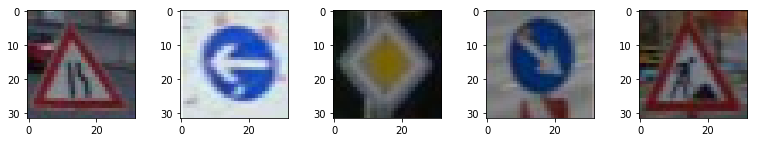

In [17]:
show_image_row(signs_from_internet['features'])

### Predict the Sign Type for Each Image

In [18]:
### Calculate the accuracy for these 5 new images. 
y_one_hot_check = label_binarizer.fit_transform(y_check)
X_check_normalized = normalize(reshape(grayscale(X_check)))
pred = model.predict(X_check_normalized)

ind = np.argpartition(pred, -1)[:,-1:]
sign_names_list= list(sign_names.SignName)
sink = [print(
    "{} - {:30s} Probability: {:3.4f}% "
    .format(index, sign_names_list[i[0]], p[i][0]*100)) for index, (p, i) in enumerate(zip(pred, ind))
       ]


0 - Road narrows on the right      Probability: 71.3604% 
1 - No passing                     Probability: 99.6103% 
2 - Priority road                  Probability: 100.0000% 
3 - Keep right                     Probability: 99.9985% 
4 - Road work                      Probability: 99.9960% 


### Analyze Performance

In [19]:
flat_indices = ind.flatten()
equals = np.equal(np.array(y_check), flat_indices)
performance = 100 * len(equals[equals == True]) / len(equals)
print('Performance is:{:7.2f}%'.format(performance))


Performance is:  60.00%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

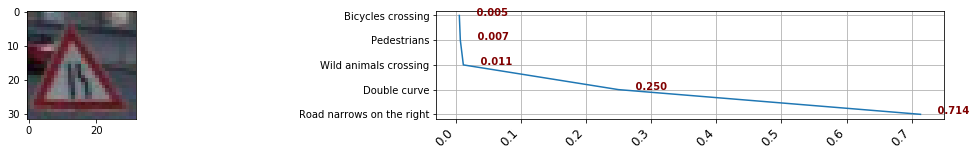

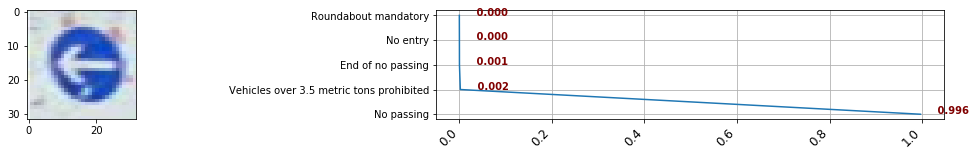

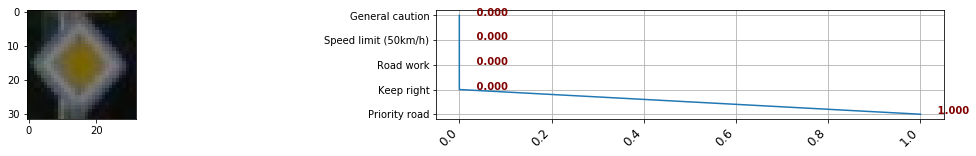

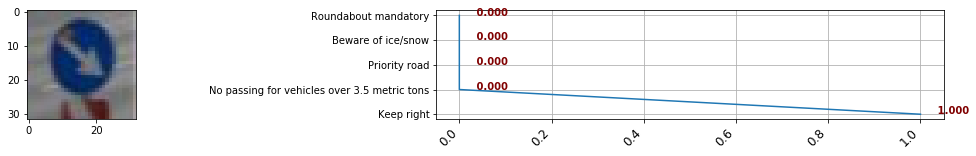

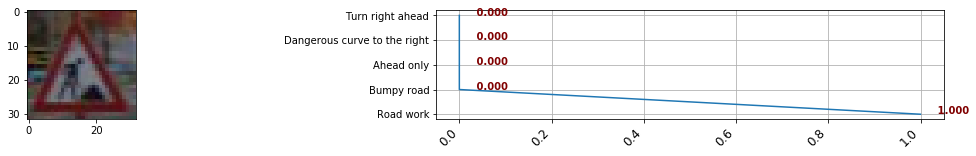

In [20]:
def show_plots(top_predictions):
    for image, prediction in zip(X_check, top_predictions):
        df1 = pd.DataFrame.from_records(prediction, columns = ['name', 'score'])
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 2))
        ax1.imshow(image)
        plt.grid()
        ax2.plot(df1.score,df1.name)
        
        for i, v in enumerate(df1.score):
            ax2.text(v, i, "{:10.3f}".format(v), color='maroon', fontweight='bold')
        
        for tick in ax2.get_xticklabels():
            tick.set_rotation(45)
            tick.set_rotation_mode('default')
            tick.set_size('large')
            tick.set_horizontalalignment('right')

k = [get_top_n_with_sign_name(p, 5) for p in pred]
np.set_printoptions(precision=2, suppress=True )
show_plots(k)

In [21]:
from keras import backend as K
def visualize_layer(layer, img_to_visualize):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    
    def convout1_f(X):
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(14,8))
    for i in range(convolutions.shape[-1]):
        ax = fig.add_subplot(3,7,i+1)
        ax.axis('off')
        img = ax.imshow(convolutions[:,:,i-1], cmap='gray')

In [22]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

### Activation maps of the first and second convolutional layers

### Activaton map of the first convolutional layer:

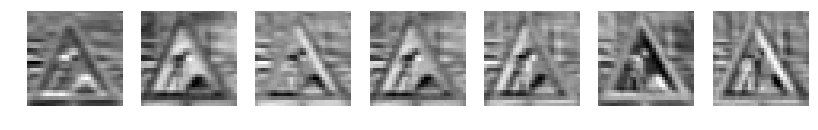

In [23]:
# Specify the layer to want to visualize
printmd('### Activaton map of the first convolutional layer:')
visualize_layer(conv1, [X_check_normalized[4]])


### Activaton map of the second convolutional layer:

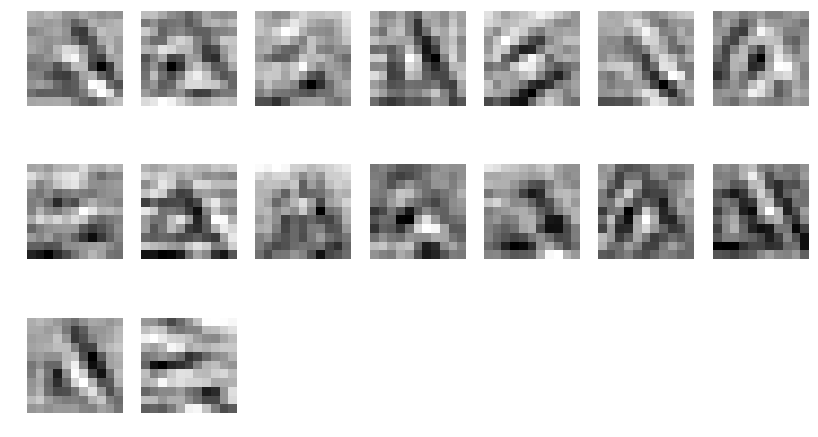

In [24]:
printmd('### Activaton map of the second convolutional layer:')
visualize_layer(conv2, [X_check_normalized[4]])